# Task 2. Sketching

Build code for computing a COUNT-MIN sketch, play with different heights and widths for the Count-Min sketch matrix. Compare it to the RESERVOIR sampling strategy. Is it more space-efficient/accurate? What about run-time? Use the theory to explain any differences you observe.

Here we use scenario 2 (CTU-Malware-Capture-Botnet-43) for the task. 

Per the documentaion for the dataset, the number of differnt types of flow on this scenario is:

| Total flows | Botnet flows | Normal flows | C&C flows | Background flows |
|-------------|--------------|--------------|-----------|------------------|
| 1,808,122   | 1.04%        |  0.5%        | 0.11%     | 98.33%           |

The infected IP address is ***147.32.84.165***.

## Data Preparation

In [6]:
import struct
import hashlib
import sys
import random as rd
import numpy as np
import struct
from math import log, inf
from pylab import *
import pandas as pd
import matplotlib.pyplot as plt
import time

Reading the file with the stream

In [7]:
# define filepath for scenario 1 dataset
filepath = './data/capture20110811.pcap.netflow.labeled'

# read data from the file
f = open(filepath, 'r')
lines = f.readlines()
f.close()
data = lines[1:] # drop the header

Preparing the data

In [8]:
def preprocessing(data):
    '''data preprocessing
    Input
    -----
    string of a data flow
    
    Return
    ------
    ip_address and label
    '''
    s = data.split('\t')
    s = [x for x in s if x] # remove empty elements
    # modify data type
    o = np.array([s[3].split(':')[0], #ScrAddr
                  s[5].split(':')[0], #DstAddr
                  s[11].rstrip('\n').rstrip() #Label
                 ])
    return o

Creating a data frame using the function above

In [9]:
df = pd.DataFrame(list(map(preprocessing, data)), columns=['ScrAddr', 'DstAddr', 'Label'])

## Creating the min-count sketch functions

Creating funtion that generates a random hash

In [10]:
#Getting how many bits your python is running om
PythonBits=struct.calcsize("P") * 8
#Generating random hash function
def hash_function():
    
    #Generating a random number
    n=rd.randint(1,10**15)
    
    #Generating a random seed
    rd.seed(n)
    
    #Generating a random bit
    random_bit = rd.getrandbits(PythonBits)
 
    #Definining a hash function using the random bit
    def randomhash(x):
        return hash(x) ^ random_bit
    
    return randomhash

Creating a function that skecth a stream give an epsilon and a delta

In [11]:
#Creating function that skecth

def Sketch(stream,epsilon,delta):
    
    #Calculating skectch dimensions based on epsilon and delta
    Vector_Size = int(2/epsilon)
    NumberOfHashFunctions = int(log(1/delta))
    
    #Creating matrix with zeros
    Matrix=np.zeros([NumberOfHashFunctions,Vector_Size])
    
    #Generating 'd' hash functions
    hash_functions = [hash_function() for i in range(NumberOfHashFunctions)]
    
    #Generating matrix with zeros
    sketch_matrix = np.zeros((NumberOfHashFunctions, Vector_Size), dtype = 'int32')
    
    #Going through the stream and adding ones for the hash
    for element in stream:
        for function_counter in range(len(hash_functions)):
            row = function_counter
            column = hash_functions[function_counter](element)%Vector_Size
            sketch_matrix[row,column] += 1
    
    #Return the sketch matrix and function to be used in the query
    return [sketch_matrix,hash_functions]

Creating a function that query the sketch using the sketch matrix and the hash functions used to generate the sketch, both provided by the function "Sketch"

In [12]:
#Querying function
def query_hash(sketch_matrix,hash_functions,element):
    
    #Defining counting
    count = inf
    
    #Getting the vector_size
    Vector_Size = sketch_matrix.shape[1]
    
    #Looping through the hash functions to get the min value
    
    for function_counter in range(len(hash_functions)):
        row = function_counter
        column = hash_functions[function_counter](element) % Vector_Size
        if sketch_matrix[row,column]<count:
            count = sketch_matrix[row,column]
    return count

Testing if the function is working using a testing stream

In [13]:
#Selecting Parameters
epsilon = 0.005
delta = 0.005

#Testing for stream with 1 1s, 2 2s, 3 3s, 4 4s, 5 5s, 6 6s, 7 7s, 8 8s, and 9 9s.
stream = [1,2,2,3,3,3,4,4,4,4,5,5,5,5,5,6,6,6,6,6,6,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9]
sketch_matrix , hash_functions = Sketch(stream,epsilon,delta)

#Testing the query
for element in set(stream):
    
    query = query_hash(sketch_matrix,hash_functions,element)
    print(str(element) + " : " + str(query))

1 : 1
2 : 2
3 : 3
4 : 4
5 : 5
6 : 6
7 : 7
8 : 8
9 : 9


## Running the functions to create sketchs on the stream data provided

Creating sketching using the data frame using different heights and widths for the Count-Min sketch matrix

In [14]:
#Creating a stream in a list format from the dataframe with all the streams
ScrAddr_list = list(df.loc[:,"ScrAddr"])
DstAddr_list = list(df.loc[:,"DstAddr"])
Label_list = list(df.loc[:,"Label"])

#Playing with different heights and widths for the count-min sketch
epsilon_list = [0.0001,0.001,0.01,0.1]

delta_list = [0.0001,0.001,0.01,0.1]

#Creating dictionary to save the sketchs and hash functions
DictTime = dict()

#Looping
for epsilon in epsilon_list:
    
    for delta in delta_list:
        
        #Skecthing column 'ScrAddr'
        start_time = time.time()
        sketch_ScrAddr,hashfunctions_ScrAddr = Sketch(ScrAddr_list,epsilon,delta)
        DictTime["e:"+str(epsilon)+"|d:"+str(delta)+"|ScrAddr"] = [sketch_ScrAddr,hashfunctions_ScrAddr,(time.time() - start_time)]
        
        #Skecthing column 'DstAddr'
        start_time = time.time()
        sketch_DstAddr,hashfunctions_DstAddr = Sketch(DstAddr_list,epsilon,delta)
        DictTime["e:"+str(epsilon)+"|d:"+str(delta)+"|DstAddr"] = [sketch_DstAddr,hashfunctions_DstAddr,(time.time() - start_time)]
        
DictSketch=DictTime
#for key,value in DictTime.items():
#    print(value[2])

## Calculating the memory space used and time spent on the creation of sketchs

Calculating the memory space used for the sketch and hash functions, and organizing the time and memory space in a data frame

In [15]:
# Creatin a dataframe to time spent per column
performance_df = pd.DataFrame(columns=['Variable','Epsilon','Delta','Time','Space'])
index = 0
# Creating variable list for the loop
variables_list=['ScrAddr','DstAddr']

#Looping through all the possible skethchs
for epsilon in epsilon_list:
    
    for delta in delta_list:
        
        for variable in variables_list:
            
            #Getting the time spent in the algorithm
            time = DictTime["e:" + str(epsilon) + "|d:" + str(delta) + "|" + variable][2]
            #Getting the memory space used in the sketch and hashfunctions
            space_sketch = int(DictTime["e:" + str(epsilon) + "|d:" + str(delta) + "|" + variable][0].nbytes)
            space_hashfunctions = int(sys.getsizeof(DictTime["e:" + str(epsilon) + "|d:" + str(delta) + "|" + variable][1]))
            total_memory_space = int(space_sketch + space_hashfunctions)
            #Append to the data frame
            performance_df.loc[index]=[variable,epsilon,delta,time,total_memory_space]
            index += 1

#Converting space to numeric            
performance_df.loc[:,"Space"] = pd.to_numeric(performance_df.loc[:,"Space"])

Plotting the time performance and the space performance by combination of delta and epsilon
obs: Uses O{(1/ε).ln(n/δ)} memory and  O{ln(n/δ)} update time


Time Performance is clearly logarithm on delta, as expected.

Text(0, 0.5, 'Time (in seconds)')

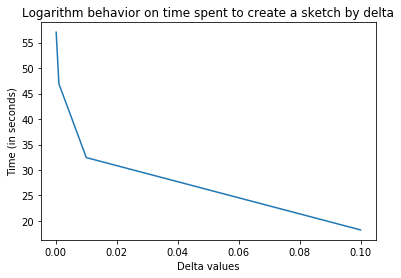

In [16]:
plt.plot(performance_df.groupby('Delta')['Time'].mean().sort_values(ascending=True))
plt.title('Logarithm behavior on time spent to create a sketch by delta')
plt.xlabel('Delta values')
plt.ylabel('Time (in seconds)')

Space Performance is clearly logarithm on delta, as expected.

Text(0, 0.5, 'Bytes')

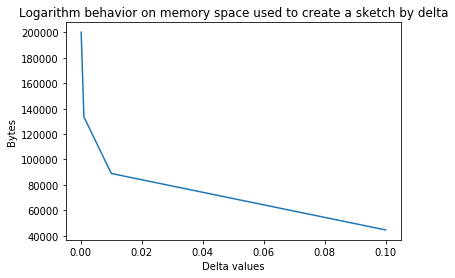

In [17]:
plt.plot(performance_df.groupby('Delta')['Space'].mean().sort_values(ascending=True))
plt.title('Logarithm behavior on memory space used to create a sketch by delta')
plt.xlabel('Delta values')
plt.ylabel('Bytes')

Space Performance is clearly linear on 1/epsilon, as expected.

Text(0, 0.5, 'Bytes')

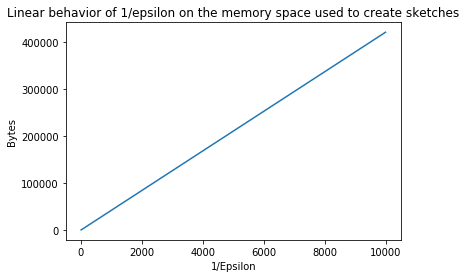

In [18]:
# Taking the ratio 1/Epsilon
performance_df1 = performance_df.copy()
performance_df1.loc[:,"Epsilon"] = 1/performance_df1.loc[:,"Epsilon"]

# Ploting
plt.plot(performance_df1.groupby('Epsilon')['Space'].mean().sort_values(ascending=True))
plt.title('Linear behavior of 1/epsilon on the memory space used to create sketches')
plt.xlabel('1/Epsilon')
plt.ylabel('Bytes')

## Comparing the performance of the sketch with the reservoir sampling

Reservoir function (the same used for task 1 but that only creates the reservoir instead of calculating the top10)

In [19]:
def reservoir_sampling(k=60000, full_df=False):
    '''sampling through a reservoir of size k
    Parameter
    ---------
    k : reservoir size
    
    Return
    ------
    top10 : the top 10 most frequent infected ip_address and freq count
    pp : proportion of reservoir size to stream size
    exe_time : execution time of reservoir sampling
    '''
    START = time.time()
    
    reservoir = list(map(preprocessing, data[:k]))
    for i in range(k+1, len(data)):
        # for pi, randomly replace j-th data in the reservoir with i-th data
        if np.random.random() < k/i: # probability pi=k/i
            j = int(np.random.randint(0, k, 1))
            reservoir[j] = preprocessing(data[i])
    reservoir_df = pd.DataFrame(reservoir, columns=['ScrAddr', 'DstAddr', 'Label'])
    
    # get the top10 most frequent ip and their frequencies
    #ips = df.loc[df['Label'] == 'Botnet']
    #infected_ips = ips.drop(columns=['Label']).values.reshape(-1) # flaten the array
    #infected_ips = np.delete(infected_ips, np.where(infected_ips == INFECTED_HOST))
    #count = np.unique(infected_ips, return_counts=True)
    #count = pd.DataFrame({'ip' : count[0],
    #                      'freq' : count[1]})
    #if not full_df: # return top 10 most frequent
    #    top10 = count.sort_values('freq', ascending=False).head(10)
    #else: # return all df
    #    top10 = count.sort_values('freq', ascending=False)
    #pp = np.round(k/len(data), 3) # proportion of reservoir size to stream size
    
    #END = time.time()
    
    return reservoir_df

### Time and Memory performance

Creating reservoirs with different sizes and calculating the time and memory space spent

In [20]:
import time
#List reservoir sizes
reservoir_sizes = [1000,10000,100000,1000000]
# Creating variable list for the loop
variables_list=['ScrAddr','DstAddr']
#Dictionary to save the size and the time spent
DictReservoir = dict()

#Looping through the reservoir_size and calculating the time spent and the reservoir
for reservoir_size in reservoir_sizes:
    
    start_time = time.time()
    reservoir_sample = reservoir_sampling(reservoir_size)
    reservoir_time_spent = (time.time() - start_time)
    
    for variable in variables_list:
        
        reservoir_sample_variable=reservoir_sample[variable]
        DictReservoir["K:"+str(reservoir_size)+"|Variable: "+variable] = [variable,reservoir_sample_variable,reservoir_time_spent]

Formating the time and memory spent into dataframes

In [21]:
# Creatin a dataframe to time spent per column
reservoir_performance_df= pd.DataFrame(columns=['Variable','K','Time','Space'])
index = 0
# Creating variable list for the loop
variables_list=['ScrAddr','DstAddr']

#Looping through all the possible skethchs
for K in reservoir_sizes:
    for variable in variables_list:
            
        #Getting the time spent in the algorithm
        time = DictReservoir["K:"+str(K)+"|Variable: "+variable][2]
        #Getting the memory space used in the sketch and hashfunctions
        space= sys.getsizeof(DictReservoir["K:"+str(K)+"|Variable: "+variable][1])
        #Append to the data frame
        reservoir_performance_df.loc[index]=[variable,K,time,space]
        index += 1

#Converting space to numeric            
reservoir_performance_df.loc[:,"Space"] = pd.to_numeric(reservoir_performance_df.loc[:,"Space"])

Time performance for reservoir

Text(0, 0.5, 'Time (in seconds)')

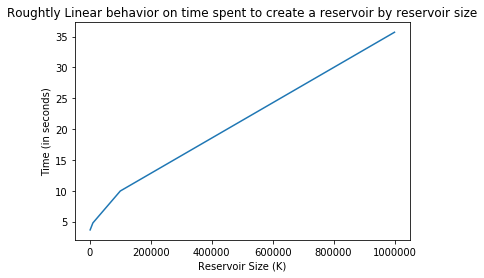

In [22]:
plt.plot(reservoir_performance_df.groupby('K')['Time'].mean().sort_values(ascending=True))
plt.title('Roughtly Linear behavior on time spent to create a reservoir by reservoir size')
plt.xlabel('Reservoir Size (K)')
plt.ylabel('Time (in seconds)')

Memory performance for the reservoir

Text(0, 0.5, 'Bytes')

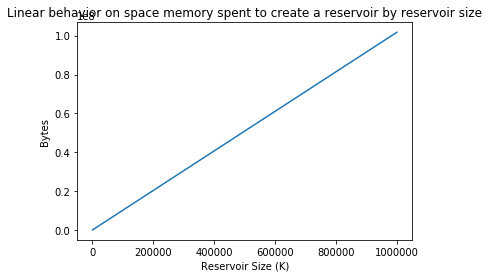

In [23]:
plt.plot(reservoir_performance_df.groupby('K')['Space'].mean().sort_values(ascending=True))
plt.title('Linear behavior on space memory spent to create a reservoir by reservoir size')
plt.xlabel('Reservoir Size (K)')
plt.ylabel('Bytes')

### Trying to find non-frequent IPs in the reservoir and in the sketch

Count in the real dataset the infect IPs that appear the most and the least

In [24]:
INFECTED_HOST = '147.32.84.165'
ips = df.loc[df['Label'] == 'Botnet']
infected_ips = ips.drop(columns=['Label']).values.reshape(-1) # flaten the array
infected_ips = np.delete(infected_ips, np.where(infected_ips == INFECTED_HOST))
count = np.unique(infected_ips, return_counts=True)
count = pd.DataFrame({'ip' : count[0],
                      'freq' : count[1]})
top10_most = count.sort_values('freq', ascending=False).head(10).reset_index()
top10_least = count.sort_values('freq', ascending=True).head(10).reset_index()


Using reservoir to verify the exitence of the infect IPs that appear the least, it can be seen that NOT EVEN ONE IP was found for ALL the reservoir created

In [25]:
reservoir_performance_df["NumberOfInexistentIPs"] = 0

for row in range(len(reservoir_performance_df)):
    
    reservoir_ScrAddr = DictReservoir["K:"+str(reservoir_performance_df.loc[row,"K"])+"|Variable: "+'ScrAddr'][1]
    reservoir_DstAddr = DictReservoir["K:"+str(reservoir_performance_df.loc[row,"K"])+"|Variable: "+'DstAddr'][1]
    number_of_inexistent_ips = 0
    
    for i in range(len(top10_least)):
        
        if (not top10_least.loc[i,"ip"] in reservoir_ScrAddr ) and (not top10_least.loc[i,"ip"] in reservoir_DstAddr) :
            
            number_of_inexistent_ips += 1
            

    reservoir_performance_df.loc[row,"NumberOfInexistentIPs"]=number_of_inexistent_ips
        
reservoir_performance_df       

,Variable,K,Time,Space,NumberOfInexistentIPs
0,ScrAddr,1000,3.657171,101809,10
1,DstAddr,1000,3.657171,101873,10
2,ScrAddr,10000,4.789639,1017311,10
3,DstAddr,10000,4.789639,1017411,10
4,ScrAddr,100000,9.966798,10172369,10
5,DstAddr,100000,9.966798,10172899,10
6,ScrAddr,1000000,35.699639,101718159,10
7,DstAddr,1000000,35.699639,101731239,10


Using sketch to verify the exitence of the infect IPs that appear the least, it can be seen ALL 10 IPs were found for ALL the sketch created - since the number of inexistent IPs is zero, it can be concluded that all were found =)

In [26]:
sketch_performance_df=performance_df.copy()
sketch_performance_df["NumberOfInexistentIPs"] = 0

for row in range(len(performance_df)):
        
        epsilon =  sketch_performance_df.loc[row,"Epsilon"]
        delta = sketch_performance_df.loc[row,"Delta"]
        
        sketch_ScrAddr = DictSketch["e:"+str(epsilon)+"|d:"+str(delta)+"|ScrAddr"][0]
        hash_ScrAddr = DictSketch["e:"+str(epsilon)+"|d:"+str(delta)+"|ScrAddr"][1]
        sketch_DstAddr = DictSketch["e:"+str(epsilon)+"|d:"+str(delta)+"|DstAddr"][0]
        hash_DstAddr = DictSketch["e:"+str(epsilon)+"|d:"+str(delta)+"|DstAddr"][1]
        
        number_of_inexistent_ips = 0
    
        for i in range(len(top10_least)):
        
            if (query_hash(sketch_ScrAddr,hash_ScrAddr,top10_least.loc[i,"ip"])==0) and (query_hash(sketch_DstAddr,hash_DstAddr,top10_least.loc[i,"ip"])==0):
            
                number_of_inexistent_ips += 1
            

        sketch_performance_df.loc[row,"NumberOfInexistentIPs"]=number_of_inexistent_ips
        
sketch_performance_df      

,Variable,Epsilon,Delta,Time,Space,NumberOfInexistentIPs
0,ScrAddr,0.0001,0.0001,47.804544,720192,0
1,DstAddr,0.0001,0.0001,71.781020,720192,0
2,ScrAddr,0.0001,0.0010,66.281808,480128,0
3,DstAddr,0.0001,0.0010,63.172588,480128,0
4,ScrAddr,0.0001,0.0100,29.119346,320096,0
5,DstAddr,0.0001,0.0100,21.146827,320096,0
6,ScrAddr,0.0001,0.1000,11.686506,160096,0
7,DstAddr,0.0001,0.1000,12.104729,160096,0
8,ScrAddr,0.0010,0.0001,44.797035,72192,0
9,DstAddr,0.0010,0.0001,45.404739,72192,0
